# Imports and Downloads

In [113]:
# kaggle imports
"""
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.12
"""

'\n!pip uninstall -y kaggle\n!pip install --upgrade pip\n!pip install kaggle==1.5.12\n'

In [114]:
# global libraries
import matplotlib.pyplot as plt
import time

In [115]:
# install deepctr
!pip install deepctr==0.8.5

  Using cached https://files.pythonhosted.org/packages/3f/c0/abde58b837e066bca19a3f7332d9d0493521d7dd6b48248451a9e3fe2214/h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: tf-nightly 2.6.0.dev20210612 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.38.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement keras-nightly~=2.5.0.dev, but you'll have keras-nightly 2.6.0.dev2021061200 which is incompatible.
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [116]:
# tensorflow nightly
!pip install tf-nightly

  Using cached https://files.pythonhosted.org/packages/9d/74/9eae2bedd8201ab464308f42c601a12d79727a1c87f0c867fdefb212c6cf/h5py-3.1.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.38.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement keras-nightly~=2.5.0.dev, but you'll have keras-nightly 2.6.0.dev2021061200 which is incompatible.
ERROR: deepctr 0.8.5 has requirement h5py==2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0


In [117]:
# relevant libraries
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm import tqdm
import os 
from deepctr.models import *
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
import random
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from collections.abc import Iterable

In [118]:
# num of CPUs
import multiprocessing
from multiprocessing import Pool
multiprocessing.cpu_count()

2

# Kaggle Dataset and Google Colab

In [119]:
# upload kaggle json permissions
"""
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
"""

'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n  \n# Then move kaggle.json into the folder where the API expects to find it.\n!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json\n'

In [120]:
# google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
# download kaggle dataset
#!kaggle competitions download -c bgu-recsys-ctr-prediction -p drive/MyDrive/RecSysKaggle/ 
#!unzip bgu-recsys-ctr-prediction.zip

In [122]:
# change directory to dataset dir
%cd  drive/MyDrive/RecSysKaggle/ 

[Errno 2] No such file or directory: 'drive/MyDrive/RecSysKaggle/'
/content/drive/MyDrive/RecSysKaggle


In [123]:
# all files names
INPUT_DATA_DIR = "train_data"

files = []

for (dirpath, dirnames, filenames) in os.walk(INPUT_DATA_DIR):
  if filenames:
    for filename in filenames:
      files.append(os.path.join(dirpath, filename))

# Memory Usage

In [124]:
# print memory usage of objects
def mem_usage(pandas_obj):
    # if it's Df
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    #if not a df it's a series
    else: 
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    print("{:03.2f} MB".format(usage_mb))

In [125]:
# Optimize memory usage - transform object columns into int, 
# float and object in order to reduce memory usage
def optimize_df(df):
  optimized_df = df.copy()

  columns_float = df.select_dtypes(include=['float'])
  converted_float = columns_float.apply(pd.to_numeric,downcast='float')
  optimized_df[converted_float.columns] = converted_float

  columns_int = df.select_dtypes(include=['int'])
  converted_int = columns_int.apply(pd.to_numeric, downcast='unsigned')
  optimized_df[converted_int.columns] = converted_int

  columns_obj = df.select_dtypes(include=['object']).copy()
  converted_obj = pd.DataFrame()
  for col in columns_obj.columns:
      converted_obj.loc[:,col] = columns_obj[col]

  optimized_df[converted_obj.columns] = converted_obj

  return optimized_df

# Preparation

In [126]:
# load and optimize Df
def load_optimize_df(csv_path):
  rca_df = pd.read_csv(csv_path)
  optimized_df = optimize_df(rca_df)
  return optimized_df

In [170]:
# set sparse, dense and target deatures for the DeepFM model
sparse_features = ['target_id_hash',	'syndicator_id_hash',
                   'campaign_id_hash',	'target_item_taxonomy',
                   'placement_id_hash',	'publisher_id_hash',
                   'source_id_hash',	'source_item_type',
                   'browser_platform', 'country_code',
                   'region', 'day_of_week','time_of_day', "os_family"]

dense_features = ['empiric_calibrated_recs',
                  'empiric_clicks',	'user_recs',	'user_clicks',
                  'user_target_recs']

target = ['is_click']

# Load Data

In [128]:
data = pd.DataFrame(columns=['page_view_start_time', 'user_id_hash', 'target_id_hash',
       'syndicator_id_hash', 'campaign_id_hash', 'empiric_calibrated_recs',
       'empiric_clicks', 'target_item_taxonomy', 'placement_id_hash',
       'user_recs', 'user_clicks', 'user_target_recs', 'publisher_id_hash',
       'source_id_hash', 'source_item_type', 'browser_platform', 'os_family',
       'country_code', 'region', 'day_of_week', 'time_of_day', 'gmt_offset',
       'is_click'])

In [129]:
# read random 10 files into memory
rand_files = random.choices(files, k=10)
for f in rand_files:
  data = data.append(load_optimize_df(f), ignore_index=True)

In [130]:
# Read test data into memory
basepath_test = "test_file.csv"
rca_df_test = load_optimize_df(basepath_test)

# Exploration

In [131]:
# find variables type and memory usage
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336831 entries, 0 to 4336830
Data columns (total 23 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   page_view_start_time     object 
 1   user_id_hash             object 
 2   target_id_hash           object 
 3   syndicator_id_hash       object 
 4   campaign_id_hash         object 
 5   empiric_calibrated_recs  float32
 6   empiric_clicks           float32
 7   target_item_taxonomy     object 
 8   placement_id_hash        object 
 9   user_recs                float32
 10  user_clicks              float32
 11  user_target_recs         float32
 12  publisher_id_hash        object 
 13  source_id_hash           object 
 14  source_item_type         object 
 15  browser_platform         object 
 16  os_family                object 
 17  country_code             object 
 18  region                   object 
 19  day_of_week              object 
 20  time_of_day              object 
 21  gmt_offs

In [132]:
# describe numeric values (dense)
data.describe()

,empiric_calibrated_recs,empiric_clicks,user_recs,user_clicks,user_target_recs,is_click
count,4.336831e+06,4.336831e+06,4.336831e+06,4.336831e+06,4.336831e+06,4.336831e+06
mean,2.817431e+04,2.476885e+04,3.694630e+02,1.815026e+01,7.335820e-01,4.998775e-01
std,6.730406e+04,4.491552e+04,3.920130e+02,3.734223e+01,2.903210e+00,5.000001e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.632475e+02,1.313000e+03,3.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.446949e+03,6.946000e+03,3.190000e+02,3.000000e+00,0.000000e+00,0.000000e+00
75%,2.096276e+04,2.691800e+04,5.310000e+02,1.900000e+01,0.000000e+00,1.000000e+00
max,1.096955e+06,7.698390e+05,7.675000e+03,1.000000e+03,1.000000e+02,1.000000e+00


In [133]:
# describe categorical values (sparse)
data.describe(include=object)

,page_view_start_time,user_id_hash,target_id_hash,syndicator_id_hash,campaign_id_hash,target_item_taxonomy,placement_id_hash,publisher_id_hash,source_id_hash,source_item_type,browser_platform,os_family,country_code,region,day_of_week,time_of_day,gmt_offset
count,4336831,4336831,4336831,4336831,4336831,4336831,4336831,4336831,4336831,4336831,4336831,4336831,4336735,4336717,4336831,4336831,4336831
unique,3852911,3263525,57887,2499,20708,65,1420,3,108318,5,4,7,287,1299,7,24,36
top,1587068820742,93324a34d6a62819cf333a77aca0f9a9b21983a7f091d5...,a121414eede8630b38ec7368707f9ef8771616118bf3c1...,139d1b7d4e3d66843ff0fffcda0e073a5a7b0ec050338b...,55e54997c2099f1eed1084a1f14698c20d33ef71da31f1...,BUSINESS,f46a38c5c8d89917121df61f7a725748354c47dfc79cfe...,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,c83159630182a5b7bc3c3fc985156c03b2a43129d63376...,text,DESK,6,US,CA,1,9,-400
freq,6,56,56114,137428,101008,775408,223001,2152734,1107899,1890478,3844502,3659613,4205553,385831,744597,313073,2041766


[]

<Figure size 432x288 with 0 Axes>

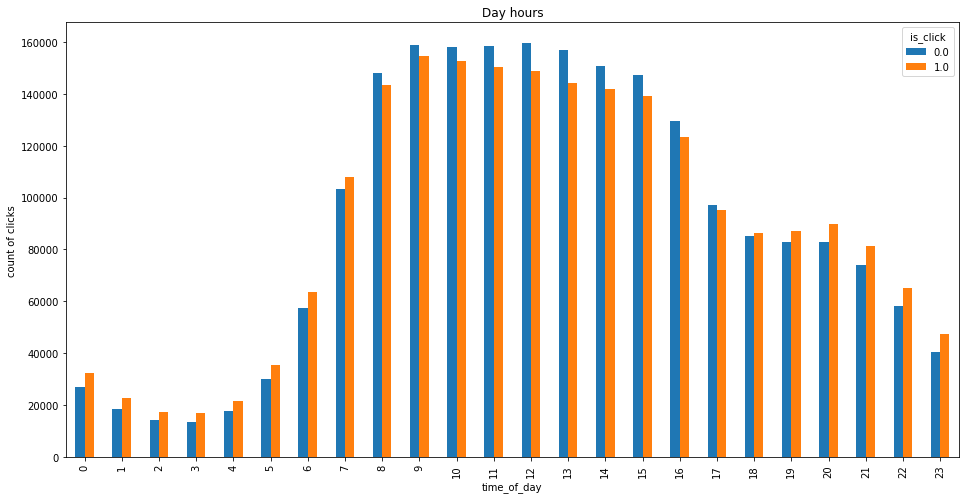

In [134]:
# Explore num of clicks as function of time of day
imp = data.groupby(['time_of_day', 'is_click']).size().unstack()
plt.figure()
imp.plot(kind='bar', title="Day hours", figsize=(16,8))
plt.ylabel("count of clicks")
plt.plot()

[]

<Figure size 432x288 with 0 Axes>

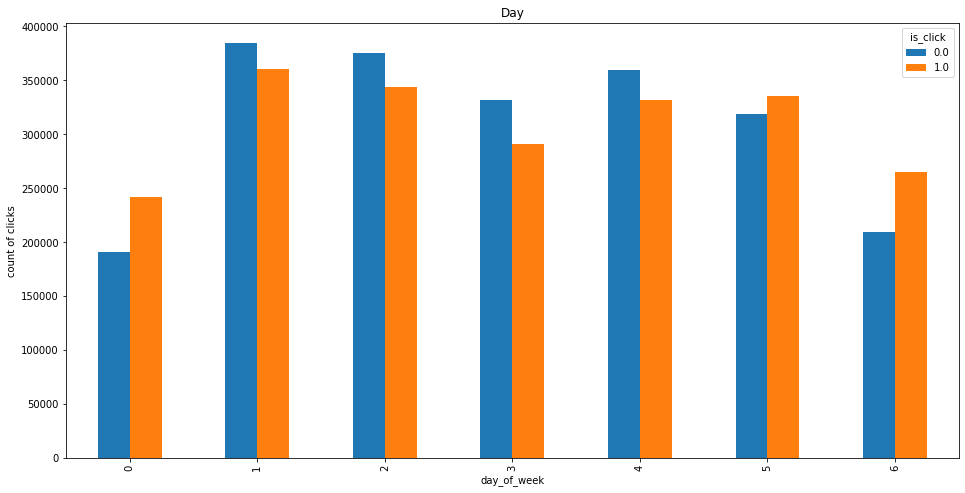

In [135]:
# Explore num of clicks as function of days
imp = data.groupby(['day_of_week', 'is_click']).size().unstack()
plt.figure()
imp.plot(kind='bar', title="Day", figsize=(16,8))
plt.ylabel("count of clicks")
plt.plot()

[]

<Figure size 432x288 with 0 Axes>

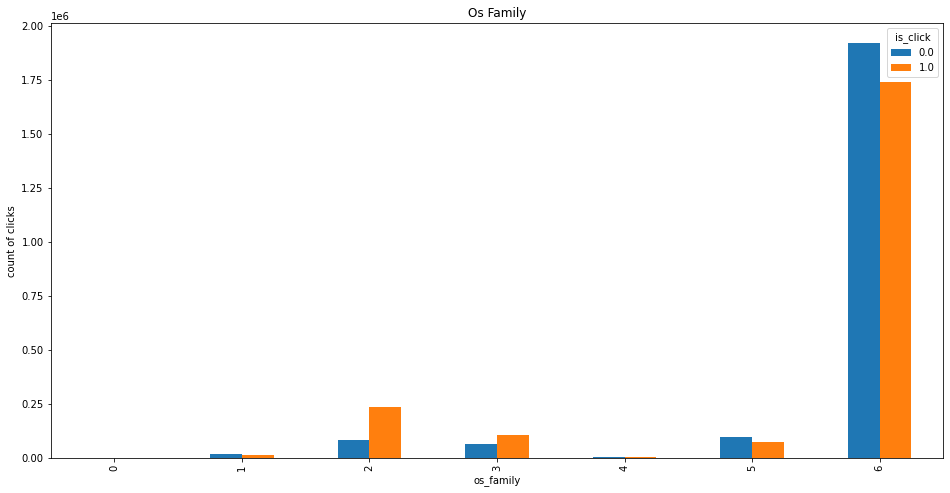

In [136]:
# Explore num of clicks as function of operating system
imp = data.groupby(['os_family', 'is_click']).size().unstack()
plt.figure()
imp.plot(kind='bar', title="Os Family", figsize=(16,8))
plt.ylabel("count of clicks")
plt.plot()

[]

<Figure size 432x288 with 0 Axes>

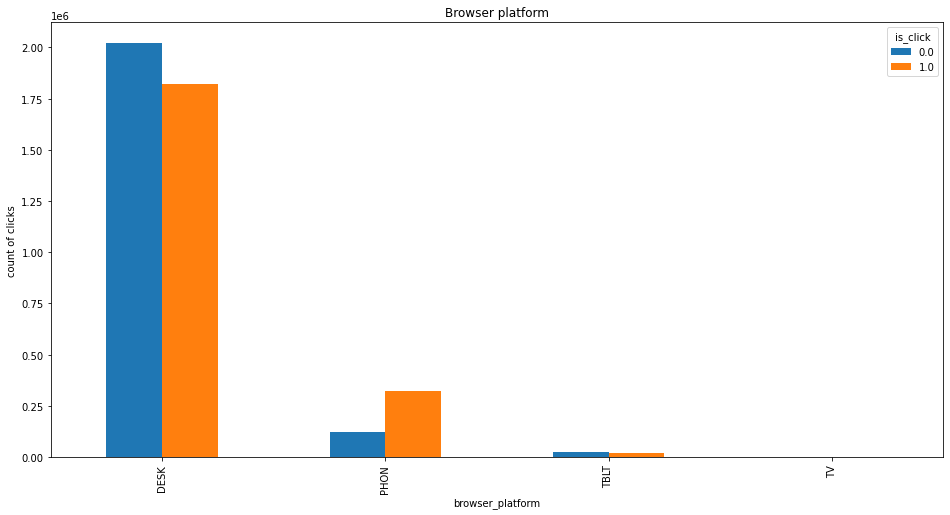

In [137]:
# Explore num of clicks as function of browser platform
imp = data.groupby(['browser_platform', 'is_click']).size().unstack()
plt.figure()
imp.plot(kind='bar', title="Browser platform", figsize=(16,8))
plt.ylabel("count of clicks")
plt.plot()

In [143]:
# Intersection users between test and train 
print(f'Users intersections : {len(set(rca_df_test["user_id_hash"].unique()).intersection(set(data["user_id_hash"].unique())))}')
print(f'train : {len(set(data["user_id_hash"].unique()))}')
print(f'test: {len(set(rca_df_test["user_id_hash"].unique()))}')

Users intersections : 0
train : 3263525
test: 422613


As we can see, there are 0 intersections of users between train and test sets, 
So we decided to remove this column from the datasets.

In [144]:
# Intersection item between test and train 
print(f'Target intersections : {len(set(rca_df_test["target_id_hash"].unique()).intersection(set(data["target_id_hash"].unique())))}')
print(f'train : {len(set(data["target_id_hash"].unique()))}')
print(f'test: {len(set(rca_df_test["target_id_hash"].unique()))}')

Target intersections : 12086
train : 57887
test: 15303


# Split train validation

In [145]:
# take only records with targets that exist in test set
data_filtered = data[data["target_id_hash"].isin(rca_df_test["target_id_hash"].unique())]
data_filtered

,page_view_start_time,user_id_hash,target_id_hash,syndicator_id_hash,campaign_id_hash,empiric_calibrated_recs,empiric_clicks,target_item_taxonomy,placement_id_hash,user_recs,user_clicks,user_target_recs,publisher_id_hash,source_id_hash,source_item_type,browser_platform,os_family,country_code,region,day_of_week,time_of_day,gmt_offset,is_click
0,1586664815841,55a1455382d08e01513b1abd95faa2adbb806987ec55a5...,c43ba981103d404347297f9f29f8976162f100ecff1d5a...,a31e99d37753a5d6b7ac7a0f2d2824b44fb52dfb673da7...,8b835bd2050a9f5a33eaa9715380614de4e046cdc1f714...,605.884094,5343.0,ENTERTAINMENT,c6c97bd91dab8077617305d4dc9be2c1dfe6aba106f08b...,589.0,23.0,0.0,c29a980222a2a97b74ffbd067f2a4ce760e3e8d8f02494...,4c7987d659b97d2007c45bb3c9fd903b135a2ef18130f7...,homepage,DESK,5,US,OH,0,0,-400,1.0
2,1587045094042,6884bd54651d71fd3b74e1c255b00cdda7fa7440927b4c...,80f737e0fa8dadcef1d34f9713461f2197b5de98d7edeb...,733eae957fba25a060d9b28810ea6edb9b5e2a9d2d7241...,e43d166e8197a299bf9c3d8ea0212de19464bbea94d9b4...,643.830566,1926.0,LIFE~FASHION,39d46cdd8f08693dd0cb967d016efec97d0bc5eb1899dc...,534.0,60.0,0.0,f8a7ba9b7c9b05464ee98daac522b3f3d2376453c70e57...,c83159630182a5b7bc3c3fc985156c03b2a43129d63376...,homepage,DESK,6,US,IN,4,9,-400,1.0
3,1586734980254,66ab17555d1cb38cbbd8b154b034df23e7e53aed1223b5...,dcf49550cf5b77473b2cb0f469a26769dee4b9de4885a6...,e4e85541c71dc9597b379e26645275b2c66edc43f71173...,0c85ca153e3f26ccb21e18166d7fc4790ef457649a60e5...,23920.115234,38538.0,LIFE~HEALTH,1fd7638e7057ac3ca2507f63cd5ac719375386f51a15b1...,2.0,0.0,0.0,f8a7ba9b7c9b05464ee98daac522b3f3d2376453c70e57...,c83159630182a5b7bc3c3fc985156c03b2a43129d63376...,homepage,DESK,6,US,OH,0,19,-400,1.0
6,1587219481558,47632ec8623e4d29351e9c391c499eb8a79ea3aeb80d47...,21c722fb4782340927ee0da0d48d48342af47dee7b0ccf...,c7c95ed0a3ecd1115889a8e6483b040d8c4407829d2a13...,d7fa768a08bcced4b0e3060dfb77af7c6ee516c48f8341...,11309.826172,4561.0,SPORTS,3e169c2c7c217891ced33c35c10f01ba9b1a830e58ff24...,409.0,1.0,5.0,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,c984801c82c6f18bcc6c166a5eacd0503f462c2f257c51...,text,DESK,6,PR,UNKNOWN,6,10,-400,0.0
8,1586419393061,3d608acd11bd38d9728e36804ed1a2cf4ee8f51645fb4b...,0e9cd877e6c7167a11e238a1bec58ec1984d223247a6bf...,8306aa8ca098af4fdb9346d1239d05dd928985fa2e95d9...,02721aa31eed25fcc520352aaf8ebae768ce2fe2b34a55...,1237.845825,171.0,BUSINESS,e1999a72622caae58e94f73f9789b22b3f849ef0b11f6e...,431.0,0.0,0.0,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,43570b08c1b694037f9ac244ffb816fae4a36caf0ce2a9...,text,DESK,6,US,SD,4,3,-500,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336826,1586910210228,ca8d88019fff5277fcf9a96703aeaabe35f284af5222d5...,5f9256c388840483313b2779b9cc9a54d608b566f2f737...,aeb3b392d01e8117900ec69a85a2e8a98eb174863cb3e9...,e66e1861c06e80f835e71ea277ef831fb693931a013a6a...,100.084137,292.0,ENTERTAINMENT,2a1989e08355c7e9539e9b9a01c9a7f7869d75bf071b9b...,181.0,6.0,0.0,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,bc2692a161c52854276407629d2d0c42dea03ad6b70cbd...,photo,PHON,2,US,NY,2,20,-400,1.0
4336827,1586893510288,46239ad919ef4a70aaea61bda7847654b1750f0d86d9b6...,14535fb98ddfc699d4e171eb66cd029087643ce8eb8e07...,4428e3d0a6542eda13ebb862cb20c6317b4ab81509972c...,b0bb57c38ec6f52f6464e2da3b96ec1152414badcdb2d3...,251.916733,2994.0,SPORTS,d85e09d9ae23581045908b7c99558421828017306677c6...,422.0,250.0,0.0,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,e931df9d172c34a4b08bb3de003ded74dc4c78be8162ff...,video,DESK,6,US,TX,2,14,-500,1.0
4336828,1586448647206,c5c4f04453bdbb3d56e107c6dc4a3a43e98be7d434ea36...,2e9ae81efa5bcdf7daff38b605f39d48f5b308d6a5352e...,22fe3033fa3934361e778318421398669b17ef75991710...,762c8d785d57c2c3a2ce0c4b2d114b56f16bc269afbf72...,386.188110,2070.0,LIFE~PETS,2e427669f363241a9eaba229dacac935e2f23c2a54b0f8...,738.0,6.0,0.0,848b127dbd0f3a647581f4a95325f5204f4577ad7956f6...,77461991264f5371df01f7392892103aa6378ecbaa0560...,video,DESK,6,US,MA,4,12,-4

In [ ]:
# Remove duplicate records
data_filtered.drop_duplicates(keep='last', inplace=True)

In [147]:
# split train and test
train, val = train_test_split(data_filtered, train_size = 0.8)

In [148]:
# Split feature columns from target
X_train = train.iloc[:,:-1]
X_val = val.iloc[:,:-1]
X_test = rca_df_test.iloc[:,:-1]

y_train = train["is_click"]
y_val = val["is_click"]
y_test = rca_df_test["Id"]

#Pre process

In [149]:
# transform page_view_start_time into date - and take only the day because month and year same for each record (April 2020)
def transform_unix_to_date(df):
  df["page_view_start_time_date"] = pd.to_datetime(df["page_view_start_time"], unit='ms')
  df["day"] =  df["page_view_start_time_date"].dt.day
  df.drop(["page_view_start_time", "gmt_offset", "page_view_start_time_date"], axis=1,inplace= True) # removed because time of day already contains the gmt offset
  return df

In [150]:
# remove userid because cold start problem
def drop_userid(df):
  return df.drop(columns='user_id_hash')

In [151]:
# fill nan values with defaults of Unknwon for sparse and 0 for dense
def fill_na(df):
  df[sparse_features] = df[sparse_features].fillna('Unknown', )
  df[dense_features] = df[dense_features].fillna(0, )
  return df

In [152]:
# run preprocess
def run_preprocess(df):
  df = drop_userid(df)
  df = transform_unix_to_date(df)
  df = fill_na(df)
  return df

In [153]:
X_train = run_preprocess(X_train)
X_val = run_preprocess(X_val)
X_test = run_preprocess(X_test)

# Encode features

In [154]:
class CategoryEncoder(object):
    """
    Once fit method is called, sklearn.preprocessing.LabelEncoder cannot encode new categories. 
    In this category encoder, fit can be called any number times. It encodes categories which it has not seen before,
    without changing the encoding of existing categories. 
    
    The first category has encoded value of one. value of zero belongs to Unknown key
    """
    start = 1
    
    def __init__(self, start=1):
        self.mapping = {}
        self.start = start
        
    def fit(self, l):
        if not isinstance(l, Iterable):
            l = [l]
        for o in l:
            if o not in self.mapping.keys():
                self.mapping[o] = len(self.mapping.keys()) + self.start
        self.mapping["Unknown"] = 0
        return self
                
    def transform(self, l):
        if isinstance(l, Iterable):
            return [self.mapping.get(o,0) for o in l]
        else:
            return self.mapping.get(l,0)
    
    def fit_transform(self,l):
        self.fit(l)
        return self.transform(l) 

In [155]:
# Scale dense features with MinMaxScaler - fit on train and trasnform train, test and validation
mms = MinMaxScaler(feature_range=(0,1))
X_train[dense_features] = mms.fit_transform(X_train[dense_features])
X_val[dense_features] = mms.transform(X_val[dense_features])
X_test[dense_features] = mms.transform(X_test[dense_features])

In [156]:
# Encode sparse features with CategoryEncoder Class - fit on train and trasnform train, test and validation
for feat in sparse_features:
  cae = CategoryEncoder()
  X_train[feat] = cae.fit_transform(X_train[feat])
  X_val[feat] = cae.transform(X_val[feat])
  X_test[feat] = cae.transform(X_test[feat])

In [157]:
# Number of unique values in sparse features
for feat in sparse_features:
  print(f"{feat}: {len(X_train[feat].unique())}")

target_id_hash: 11867
syndicator_id_hash: 1386
campaign_id_hash: 5926
target_item_taxonomy: 61
placement_id_hash: 1311
publisher_id_hash: 3
source_id_hash: 82127
source_item_type: 5
browser_platform: 4
country_code: 264
region: 1179
day_of_week: 7
time_of_day: 24
os_family: 7


In [158]:
# Show data
X_train

,target_id_hash,syndicator_id_hash,campaign_id_hash,empiric_calibrated_recs,empiric_clicks,target_item_taxonomy,placement_id_hash,user_recs,user_clicks,user_target_recs,publisher_id_hash,source_id_hash,source_item_type,browser_platform,os_family,country_code,region,day_of_week,time_of_day,day
3765749,1,1,1,6.369542e-02,0.287813,1,1,0.000000,0.000,0.00,1,1,1,1,1,1,1,1,1,11
487214,2,2,2,1.589501e-02,0.006857,2,2,0.000000,0.000,0.00,2,2,1,1,1,1,2,2,2,8
2158485,3,3,3,1.098522e-02,0.007956,3,3,0.045342,0.004,0.03,3,3,2,1,1,1,3,2,2,15
2493281,4,4,4,6.012914e-08,0.000001,1,4,0.060065,0.028,0.00,3,4,2,2,2,1,4,3,3,14
1849730,5,5,5,7.304479e-03,0.010066,4,5,0.006515,0.000,0.00,3,5,3,1,1,1,2,2,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988041,897,20,691,1.339278e-02,0.013837,21,36,0.000000,0.000,0.00,1,1,1,1,1,1,22,6,20,6
1949018,261,119,153,1.008432e-04,0.002107,5,49,0.130423,0.128,0.01,3,28243,3,1,1,1,7,7,17,13
4086958,407,36,347,9.196708e-02,0.121092,12,135,0.023844,0.016,0.00,3,10873,2,1,1,1,25,1,10,10
320362,1571,24,141,1.798286e-02,0.020265,2,57,0.039088,0.038,0.00,1,1,1,1,1,1,3,6,3,6


# DeepFM Preprocessing

In [180]:
# the firsts sparse vector for sprase features, the second for small categorcial features, and dense vector for dense features 
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=X_train[feat].max()+1,embedding_dim=4)
                              for feat in sparse_features] + [DenseFeat(feat, 1, )
                          for feat in dense_features]

In [181]:
# both go to embedding and dnn
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [182]:
# Create train input for DeepFM
input_train = {name:X_train[name] for name in feature_names}
output_train = y_train.values

In [183]:
# Create validation input for DeepFM
input_val = {name:X_val[name] for name in feature_names}
output_val = y_val.values

In [184]:
# Create test input for DeepFM
input_test = {name:X_test[name] for name in feature_names}

#Build Model

In [185]:
# Define loss function. Although some loss functions are build-in functions and are available to use, this is an example of how you can create\define your own loss function.
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [186]:
# Build Model
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary', l2_reg_embedding=0.2)

In [187]:
# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.AUC()], )

In [188]:
# Train model with early stopping
es = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(input_train, output_train,
                    batch_size=16000, epochs=10, verbose=1, validation_data=(input_val, output_val), callbacks=[es])

Epoch 1/10
145/145 [==============================] - 24s 142ms/step - loss: 4.2571 - root_mean_squared_error: 0.4639 - auc_4: 0.7855 - val_loss: 1.2322 - val_root_mean_squared_error: 0.4408 - val_auc_4: 0.8152
Epoch 2/10
145/145 [==============================] - 20s 140ms/step - loss: 0.7630 - root_mean_squared_error: 0.4290 - auc_4: 0.8217 - val_loss: 0.5655 - val_root_mean_squared_error: 0.4207 - val_auc_4: 0.8266
Epoch 3/10
145/145 [==============================] - 20s 139ms/step - loss: 0.5338 - root_mean_squared_error: 0.4155 - auc_4: 0.8306 - val_loss: 0.5195 - val_root_mean_squared_error: 0.4123 - val_auc_4: 0.8321
Epoch 4/10
145/145 [==============================] - 20s 139ms/step - loss: 0.5124 - root_mean_squared_error: 0.4093 - auc_4: 0.8351 - val_loss: 0.5094 - val_root_mean_squared_error: 0.4082 - val_auc_4: 0.8353
Epoch 5/10
145/145 [==============================] - 20s 140ms/step - loss: 0.5048 - root_mean_squared_error: 0.4060 - auc_4: 0.8380 - val_loss: 0.5040 - v

#Test

In [ ]:
pred = model.predict(input_test)
pred_df = pd.DataFrame(pred)
pred_df.reset_index(inplace=True)
pred_df.columns = ['Id','Predicted']
pred_df.to_csv('my_submission.csv',index=False)